In [2]:

#%pip install -q --upgrade pip
#%pip install -q "tensorflow>=2.11" "tensorflow-probability>=0.19" matplotlib seaborn numpy tf-keras

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors
print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)




TF version: 2.20.0
TFP version: 0.25.0


In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [4]:
dataset_path = 'C:\\Users\\rodri\\Downloads\\images' #Cambiar esta ruta dónde se descargue el dataset 

datagen = ImageDataGenerator(validation_split=0.3)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
test_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 252 images belonging to 9 classes.
Found 107 images belonging to 9 classes.


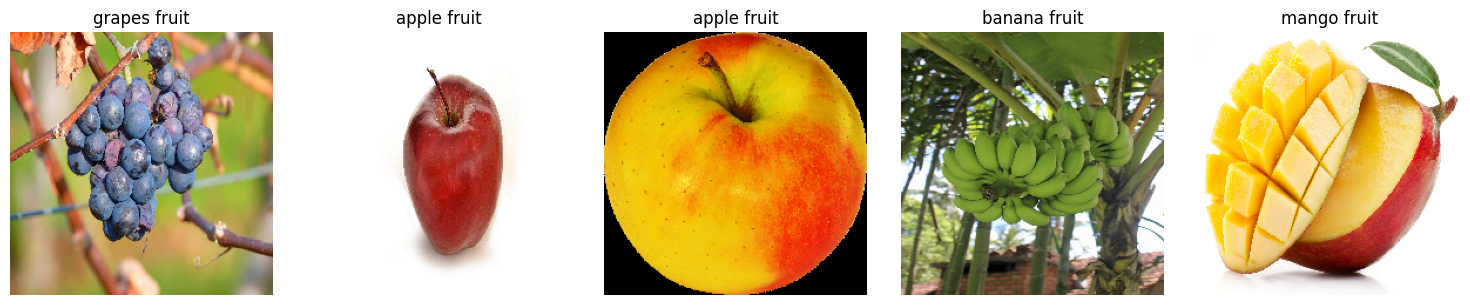

In [5]:

images, labels = next(train_generator)   

class_names = list(train_generator.class_indices.keys()) 

n_examples = 5  
fig, axs = plt.subplots(1, n_examples, figsize=(n_examples*3, 3))
for j in range(n_examples):
    
    img = images[j]
    axs[j].imshow(img.astype('uint8') if img.dtype != 'uint8' else img)
    if labels.ndim > 1:
        lbl = class_names[np.argmax(labels[j])]
    else:
        lbl = class_names[int(labels[j])]
    axs[j].set_title(lbl)
    axs[j].axis('off')
plt.tight_layout()
plt.show()

In [6]:

encoded_dim = 32

encoder = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(encoded_dim, activation="relu") 
])

c:\Users\rodri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:

images_batch, labels_batch = next(train_generator)  

n_examples = min(32, images_batch.shape[0])
example_images = images_batch[:n_examples]
example_labels = labels_batch[:n_examples]


imgs_resized = tf.image.resize(example_images, [28, 28])  


if imgs_resized.shape[-1] == 3:
    imgs_resized = tf.image.rgb_to_grayscale(imgs_resized)  
    imgs_resized = tf.squeeze(imgs_resized, axis=-1)        


imgs_resized = tf.cast(imgs_resized, tf.float32)
imgs_resized_norm = imgs_resized / 255.0


example_images_resized = imgs_resized 

pretrain_example_encodings = encoder(imgs_resized_norm).numpy()
pretrain_example_encodings.shape


(32, 32)

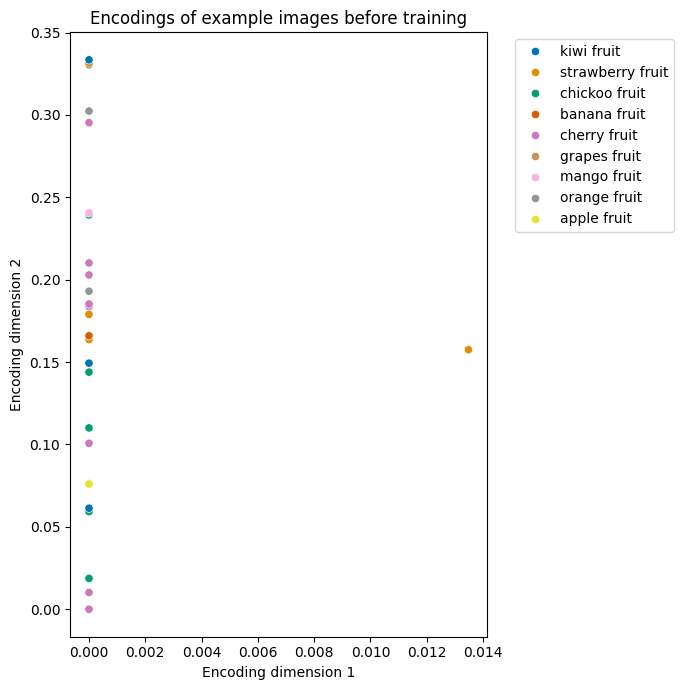

In [8]:

if example_labels.ndim > 1:
    label_indices = np.argmax(example_labels, axis=1)
else:
    label_indices = example_labels.astype(int)

class_names = list(train_generator.class_indices.keys())
label_names = [class_names[i] for i in label_indices]

f, ax = plt.subplots(1, 1, figsize=(7, 7))

sns.scatterplot(x=pretrain_example_encodings[:, 0],
                y=pretrain_example_encodings[:, 1],
                hue=label_names, ax=ax,
                palette=sns.color_palette("colorblind", n_colors=len(class_names)))
ax.set_xlabel('Encoding dimension 1')
ax.set_ylabel('Encoding dimension 2')
ax.set_title('Encodings of example images before training')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [9]:

decoder = Sequential([
    Dense(128, activation="relu", input_shape=(encoded_dim,)),
    Dense(256, activation="relu"),
    Dense(512, activation="relu"),
    Dense((28*28), activation="sigmoid"), 
    Reshape((28, 28))
])

c:\Users\rodri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:

input_img = tf.keras.Input(shape=(28, 28))
encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', 
                loss='binary_crossentropy',
                metrics=['binary_crossentropy','mse'])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 32)             │       570,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 28, 28)         │       571,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,141,296 (4.35 MB)

 Trainable params: 1,141,296 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:

try:
    x_train = imgs_resized_norm
except NameError:
    

    tmp = tf.image.resize(example_images, [28, 28])
    if tmp.shape[-1] == 3:
        tmp = tf.image.rgb_to_grayscale(tmp)
        tmp = tf.squeeze(tmp, axis=-1)
    tmp = tf.cast(tmp, tf.float32) / 255.0
    x_train = tmp

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,  
    restore_best_weights=True,
    min_delta=0.001  
)

history = autoencoder.fit(
    x=x_train, 
    y=x_train, 
    epochs=100,  
    batch_size=min(32, x_train.shape[0]),
    validation_split=0.1,  
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - binary_crossentropy: 0.6931 - loss: 0.6931 - mse: 0.0941 - val_binary_crossentropy: 0.6901 - val_loss: 0.6901 - val_mse: 0.1189
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - binary_crossentropy: 0.6903 - loss: 0.6903 - mse: 0.0927 - val_binary_crossentropy: 0.6794 - val_loss: 0.6794 - val_mse: 0.1136
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - binary_crossentropy: 0.6800 - loss: 0.6800 - mse: 0.0876 - val_binary_crossentropy: 0.6616 - val_loss: 0.6616 - val_mse: 0.1052
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - binary_crossentropy: 0.6627 - loss: 0.6627 - mse: 0.0794 - val_binary_crossentropy: 0.6481 - val_loss: 0.6481 - val_mse: 0.0995
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - binary_crossentropy: 0.6496 - loss: 0.6496 - mse: 0.0740 - val_binary_crossentropy: 0.6364 - val_loss: 0.6364 - val_mse: 0.0945
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - binary_crossentropy: 0.6367 - loss: 0.6367 - 

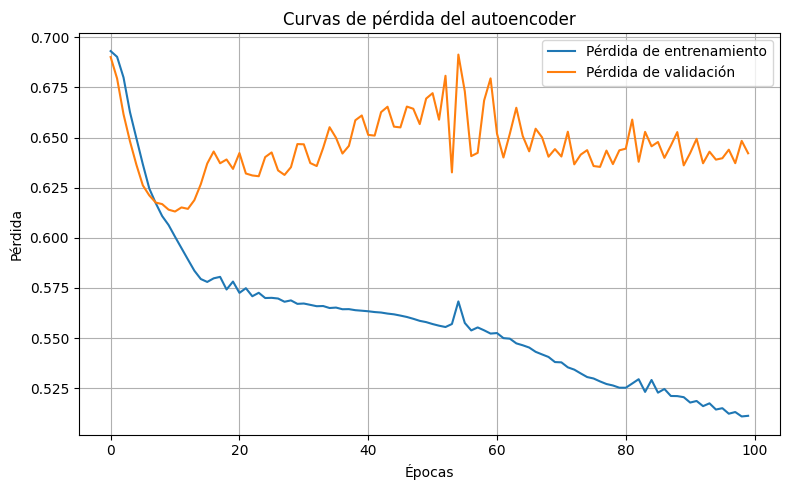

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(loss, label='Pérdida de entrenamiento')
plt.plot(val_loss, label='Pérdida de validación')
plt.title('Curvas de pérdida del autoencoder')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
posttrain_example_encodings = encoder(imgs_resized_norm).numpy()
posttrain_example_encodings

array([[0.        , 4.356346  , 0.12437533, ..., 6.348586  , 5.5787997 ,
        5.2051764 ],
       [0.        , 2.4974532 , 1.2531871 , ..., 2.7355993 , 4.265388  ,
        3.8748696 ],
       [0.        , 1.2937825 , 1.1753596 , ..., 0.09095781, 1.3794788 ,
        0.        ],
       ...,
       [0.        , 2.8651288 , 1.1148982 , ..., 5.5638547 , 3.7252946 ,
        2.2438142 ],
       [0.        , 0.        , 3.2160475 , ..., 0.9125287 , 0.10314701,
        1.631391  ],
       [0.        , 0.        , 2.628328  , ..., 0.6529486 , 1.7363584 ,
        2.9220662 ]], shape=(32, 32), dtype=float32)

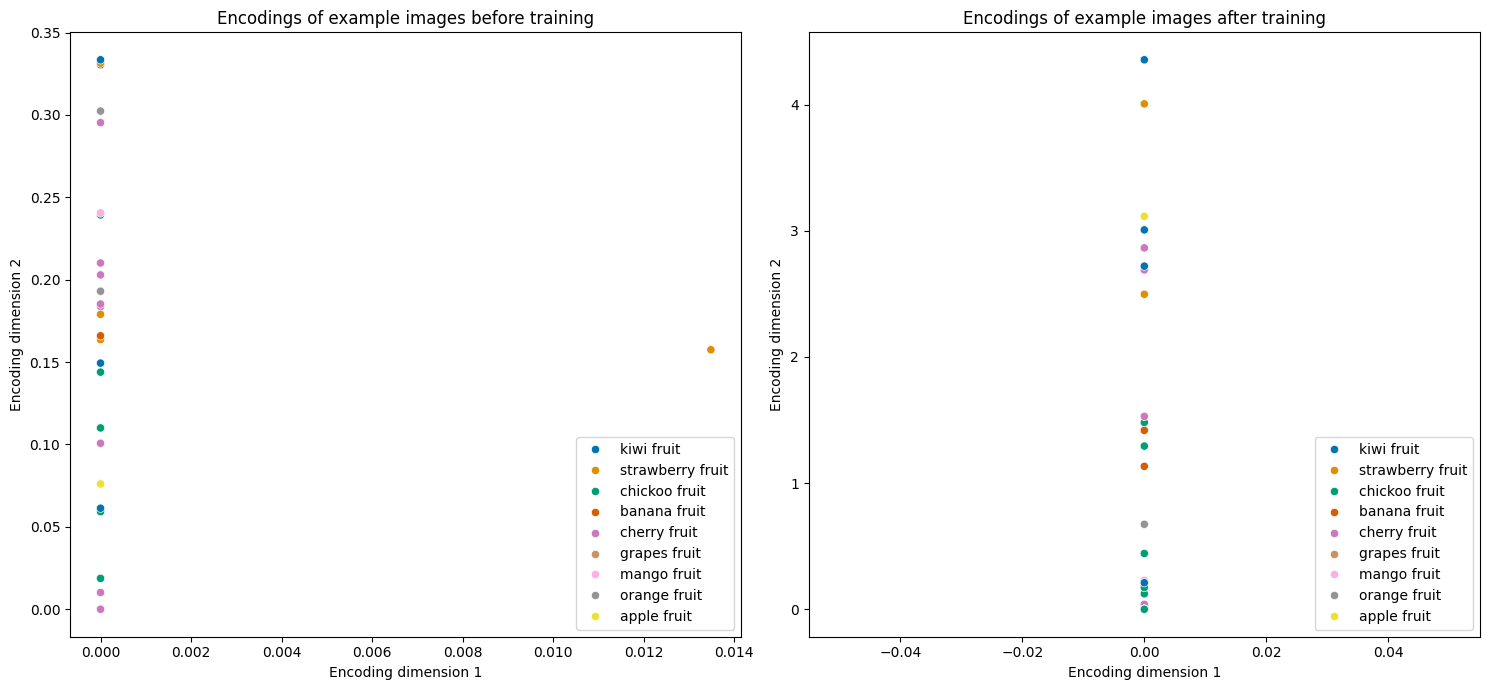

In [14]:

if example_labels.ndim > 1:
    label_indices = np.argmax(example_labels, axis=1)
else:
    label_indices = example_labels.astype(int)


class_names = list(train_generator.class_indices.keys())
label_names = [class_names[i] for i in label_indices]

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

sns.scatterplot(x=pretrain_example_encodings[:, 0],
                y=pretrain_example_encodings[:, 1],
                hue=label_names, ax=axs[0],
                palette=sns.color_palette("colorblind", n_colors=len(class_names)))

sns.scatterplot(x=posttrain_example_encodings[:, 0],
                y=posttrain_example_encodings[:, 1],
                hue=label_names, ax=axs[1],
                palette=sns.color_palette("colorblind", n_colors=len(class_names)))

axs[0].set_title('Encodings of example images before training')
axs[1].set_title('Encodings of example images after training')
for ax in axs:
    ax.set_xlabel('Encoding dimension 1')
    ax.set_ylabel('Encoding dimension 2')
    ax.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [15]:
reconstructed_example_images = autoencoder.predict(imgs_resized_norm)
reconstructed_example_images.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


(32, 28, 28)

In [16]:

reconstructed_from_encodings = decoder(posttrain_example_encodings).numpy() if hasattr(decoder(posttrain_example_encodings), 'numpy') else decoder(posttrain_example_encodings)


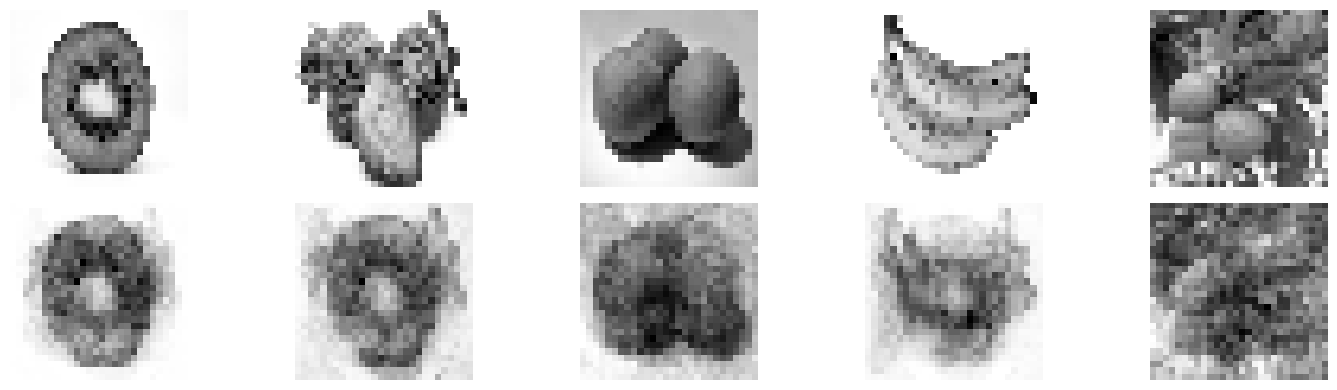

In [17]:

f, axs = plt.subplots(2, 5, figsize=(15, 4))
for j in range(5):
    
    orig = example_images_resized[j].numpy() if hasattr(example_images_resized[j], 'numpy') else example_images_resized[j]
    if orig.ndim == 2:
        axs[0, j].imshow(orig.astype('uint8'), cmap='gray')
    else:
        axs[0, j].imshow(orig.astype('uint8'))

    recon = reconstructed_example_images[j]
    if recon.ndim == 2:
        axs[1, j].imshow((recon * 255).astype('uint8'), cmap='gray')
    else:
        axs[1, j].imshow((recon * 255).astype('uint8'))

    axs[0, j].axis('off')
    axs[1, j].axis('off')
plt.tight_layout()
plt.show()


In [18]:
#autoencoder.save('autoencoder.h5')
#encoder.save('encoder.h5')
#decoder.save('decoder.h5')